Get the data from the repo -> anonymize!

In [16]:
!git clone https://github.com/tbaeumel/transformer-digit-arithmetic.git

Cloning into 'transformer-digit-arithmetic'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 689 (delta 10), reused 8 (delta 8), pack-reused 672 (from 5)
Receiving objects: 100% (689/689), 42.75 MiB | 23.89 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [17]:
!nvidia-smi

Mon Jul 28 11:09:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   76C    P0             37W /   72W |   15635MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
%cd transformer-digit-arithmetic

/content/transformer-digit-arithmetic/transformer-digit-arithmetic


Get pyvene
Olmo2 was not in pyvene - i wrote an extension so that olmo2 can be an intervenable model.
 has to be anonymized

In [4]:
# pip uninstall -y pyvene  # pyvene has to be uninstalled if a standard version is currently installed
# pip install pyvene
!pip install git+https://github.com/tbaeumel/pyvene

  Cloning https://github.com/tbaeumel/pyvene to /tmp/pip-req-build-g9c7854c
  Running command git clone --filter=blob:none --quiet https://github.com/tbaeumel/pyvene /tmp/pip-req-build-g9c7854c
  Resolved https://github.com/tbaeumel/pyvene to commit e9085b6d207d5790146921d02a8af4859406c9ea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import pyvene as pv
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import sys
import torch.nn.functional as F
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    ZeroIntervention,
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from huggingface_hub import login
import re
import numpy
from tqdm import tqdm
from matplotlib import pyplot as plt
import transformers
import os

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


## Load model

Llama 70B wont work on colab

llama 8b and olmo 2 7b will work on l4 or a100

people have to login with their huggingface key to get access to the llama models

In [6]:
# Login to Huggingface to get access to model parameters
# Paste your token here
login('')

In [7]:
# choose your model
model_name = "Llama-3-8B" # Llama-3-70B # Olmo-2-7B

In [8]:
models = {"Llama-3-8B": "meta-llama/Meta-Llama-3-8B", "Llama-3-70B": "meta-llama/Meta-Llama-3-70B", "Olmo-2-7B": "allenai/OLMo-2-1124-7B" }

# Set parameters
params = {
    'model_name': models[model_name],
    'device': "cuda" if torch.cuda.is_available() else "cpu"
}

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(params['model_name'])
model = AutoModelForCausalLM.from_pretrained(params['model_name'], torch_dtype=torch.float16).to(params['device'])

# Confirm device
print(f"Using device: {params['device']}")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
  print("Using GPU")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using device: cuda
Using GPU


# Digit circuit Intervention

Choose:
- thresholds (pre computed using Fisher scores)
- digit position (hundredth,tenth,unit)
- task (operator) (+,-)
- operand (which intervention dataset) (op1 + op2 = ..) two variation either fix op1 or op2

this can be changed to standard values for the thresholds and layers (see paper Section X), so that based on model and digti position the best threshold is chosen


In [9]:
# labels
label = "hundredth" # "tenth" # "unit"
# task (operator)
task = "addition" # "subtraction"
# which oeprand
operand = "op1" # "op2"

In [23]:
# Load the JSON file
input_file = f"Intervention_Data/intervention_data_{task}_{operand}.json"
with open(input_file, "r") as f:
    data = json.load(f)

# layer sets to intervene on based on model, task, and operand
# TODO do this elegantly

with open(f"intervene_layers.json", "r") as f:
    layer_sets = json.load(f)
layer_set = layer_sets[model_name][task][operand] ## return layers set for the corresponding experiment


with open(f"fisher_scores_threshold_map.json", "r") as f:
    threshold_map = json.load(f)
threshold = threshold_map[model_name][task][operand][label] ## return threshold float for the corresponding experiment

print("layer_set:",layer_set)
print("threshold:",threshold)

layer_set: [16, 17, 18, 19, 20, 21, 22, 23, 24]
threshold: 0.8


Extract the MLP dimensions that have a fisher score above the chosen threshold

In [24]:
# According to the threshold chosen, get the MLP dimensions per layer to be intervened on, i.e., the MLP neurons that belong to the digit circuit at that threshold

# Open the right fisher score file
with open(f"Fisher_Scores/{model_name}/{task}/fisher_scores_{label}.json", "r") as file:
    fisher_scores_data = json.load(file) # return a victor of Fisher scores for each latent in layer_i. example: for llama3-8b (layer_16: sahpe(4096), layer_17:...)


# Output dictionary
layer_subspaces_map = {}

# Iterate through best selected layers
layers = layer_set # you can choose a subset of layers to test output [16,17]
min_thresh = threshold # you can choose different threshold 0.8
for layer in layers:
    key = f"layer_{layer}"
    if key in fisher_scores_data:
        values = fisher_scores_data[key]
        indices_above_threshold = [i for i, val in enumerate(values) if val > min_thresh] ### keep neurons indices that pass the a threshold
        layer_subspaces_map[layer] = indices_above_threshold

# Result
print(layer_subspaces_map)

{16: [1, 4, 5, 6, 7, 22, 34, 42, 58, 63, 70, 71, 77, 82, 92, 102, 103, 133, 144, 147, 150, 152, 161, 165, 167, 172, 173, 186, 195, 199, 203, 206, 210, 213, 214, 223, 232, 235, 236, 245, 253, 265, 267, 271, 272, 283, 285, 289, 290, 294, 302, 304, 305, 306, 307, 321, 334, 336, 342, 344, 348, 355, 359, 363, 378, 401, 406, 413, 416, 440, 446, 450, 452, 455, 460, 475, 477, 481, 486, 488, 508, 516, 517, 518, 521, 527, 529, 541, 543, 545, 550, 555, 558, 569, 572, 576, 579, 590, 592, 596, 617, 620, 626, 638, 643, 649, 666, 670, 675, 677, 708, 717, 728, 743, 755, 758, 761, 762, 775, 793, 802, 804, 806, 810, 824, 834, 852, 853, 866, 867, 870, 880, 908, 912, 921, 934, 935, 938, 943, 946, 974, 982, 984, 985, 986, 989, 994, 1017, 1018, 1022, 1031, 1041, 1059, 1062, 1064, 1066, 1067, 1077, 1079, 1087, 1104, 1106, 1130, 1146, 1147, 1153, 1158, 1167, 1169, 1173, 1188, 1191, 1215, 1216, 1219, 1225, 1227, 1228, 1233, 1236, 1238, 1253, 1257, 1258, 1259, 1265, 1270, 1273, 1277, 1280, 1287, 1303, 1305, 131

In [25]:
################################################
# Perform Digit-Circuit Interventions on each data point #
################################################

# Iterate through each query in the dataset
for j, entry in tqdm(enumerate(data)):
    data_entry = []
    model_layers = model.config.num_hidden_layers
    window_size = 1

    sentence = entry["one_shot_base"]
    sentence_intervention = entry["one_shot_source"]

    base = tokenizer(sentence, return_tensors="pt").to(device)

    # Number of tokens
    tokenized_input = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True)
    input_ids = tokenized_input["input_ids"].to(device)
    num_tokens = input_ids.shape[1]

    ############################
    # Clean Run for comparison #
    ############################

    inputs = [tokenizer(sentence, return_tensors="pt").to(device),]
    res = model(**inputs[0])

    distrib = res.logits
    logits = distrib[0][-1]

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the top 10 tokens and their probabilities
    top_k = 50
    top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

    # Convert indices to tokens
    top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

    # Collect the data
    data_temp = []
    for token, prob in zip(top_k_tokens, top_k_probs):
        data_temp.append({
            "token": token,
            "prob": prob.detach().cpu().item()
        })

    data_entry.append({"run": "clean", "top_100": data_temp})

    ###############################################
    # Interchange Interventions across layer sets #
    ###############################################

    # Get the index of the last token using len()
    last_token_index = len(base['input_ids'][0]) - 1  # Use len() to get the length of the sequence

    # Create intervention for specific layers
    config = pv.IntervenableConfig([{
        "layer": l,
        "component": "mlp_output",
        "intervention_type": VanillaIntervention
        } for l in layer_set] # Pass a list instead of a single layer
    )

    pv_model = pv.IntervenableModel(config, model=model)

    # Define list of subspaces based on the layer_subspaces_map
    # Create an empty list to store the corresponding subspaces for each layer in layer_set
    subspaces = []

    # Loop over the layers in the current layer_set and fetch corresponding subspaces
    for layer in layer_set:
        subspaces.append(layer_subspaces_map[layer])

    # run an interchange intervention
    _, intervened_outputs = pv_model(
      # the base input
      base=tokenizer(sentence, return_tensors = "pt").to(device),
      # the source input
      sources=tokenizer(sentence_intervention, return_tensors = "pt").to(device),
      # the location to intervene at (last token)
      unit_locations={"sources->base": last_token_index},
      subspaces = subspaces
    )

    distrib = intervened_outputs.logits
    logits = distrib[0][-1]

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=-1)

    # Get the top 10 tokens and their probabilities
    top_k = 100
    top_k_probs, top_k_indices = torch.topk(probabilities, top_k)

    # Convert indices to tokens
    top_k_tokens = [tokenizer.decode(index.item()) for index in top_k_indices]

    # Collect the data
    data_temp = []
    for token, prob in zip(top_k_tokens, top_k_probs):
        data_temp.append({
            "token": token,
            "prob": prob.detach().cpu().item()
        })

    data_entry.append({"run": "intervened", "top_100": data_temp})

    df = pd.DataFrame(data_entry)

    output_dir = f"Interventions/"
    os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

    df.to_csv(f"{output_dir}/intervention_{model_name}_{task}_{operand}_{label}_threshold_{threshold}_{j}.csv")

200it [02:37,  1.27it/s]


# Evaluation

In [26]:
import os
import json
import pandas as pd
import ast
import re

variant_labels = ["bbb", "bbs", "bsb", "bss", "sbb", "sbs", "ssb", "sss"]
folder_path = "Interventions/"

# Initialize accumulators: sums and counts for each run and variant label
accumulated_probs = {
    "clean": {label: 0.0 for label in variant_labels},
    "intervened": {label: 0.0 for label in variant_labels}
}
counts = {
    "clean": {label: 0 for label in variant_labels},
    "intervened": {label: 0 for label in variant_labels}
}

# Get sorted CSV files
csv_files = [f for f in os.listdir(folder_path) if re.match(r"intervention_.*_(\d+)\.csv", f)]
csv_files.sort(key=lambda x: int(re.search(r"_(\d+)", x).group(1)))

for file_name in csv_files:
    index_match = re.search(r"_(\d+)\.csv$", file_name)
    i = int(index_match.group(1)) if index_match else None
    if i is None:
        continue

    print(f"Processing example {i} from file {file_name}")
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)

    # Map variant labels to target tokens from your loaded `data`
    variant_token_map = {k: str(v) for k, v in data[i]["result_variants"].items()}

    for _, row in df.iterrows():
        run_type = row["run"]  # "clean" or "intervened"
        try:
            token_probs = ast.literal_eval(row["top_100"])
        except Exception as e:
            print(f"Error parsing token probs in {file_name}, run={run_type}: {e}")
            continue

        for variant_label, target_token in variant_token_map.items():
            for entry in token_probs:
                if entry["token"] == target_token:
                    prob = entry["prob"]
                    accumulated_probs[run_type][variant_label] += prob
                    counts[run_type][variant_label] += 1

# Compute averages over all examples and all files
averages = {
    run_type: {
        label: (accumulated_probs[run_type][label] / counts[run_type][label]) if counts[run_type][label] > 0 else 0
        for label in variant_labels
    }
    for run_type in ["clean", "intervened"]
}

# Save averages to JSON
output_file = "average_probabilities.json"
with open(output_file, "w") as f:
    json.dump(averages, f, indent=4)

print("Averages computed and saved to", output_file)

Processing example 157 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_157.csv
Processing example 193 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_193.csv
Processing example 71 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_71.csv
Processing example 155 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_155.csv
Processing example 177 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_177.csv
Processing example 69 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_69.csv
Processing example 97 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_97.csv
Processing example 191 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_191.csv
Processing example 106 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold_0.8_106.csv
Processing example 95 from file intervention_Llama-3-8B_addition_op1_hundredth_threshold

# Visualization

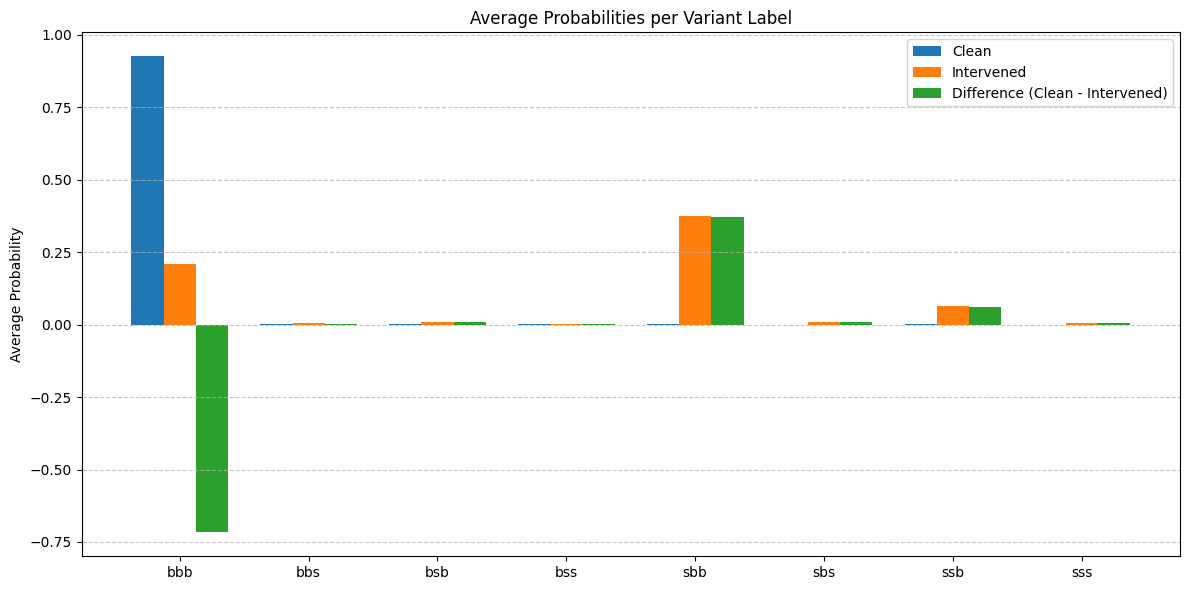

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `averages` dict is computed as before:
# averages = {
#   "clean": {...},
#   "intervened": {...}
# }

variant_labels = list(averages["clean"].keys())

clean_vals = [averages["clean"][label] for label in variant_labels]
intervened_vals = [averages["intervened"][label] for label in variant_labels]
diff_vals = [i - c for i, c in zip(intervened_vals, clean_vals)]

x = np.arange(len(variant_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, clean_vals, width, label='Clean', color='tab:blue')
bars2 = ax.bar(x, intervened_vals, width, label='Intervened', color='tab:orange')
bars3 = ax.bar(x + width, diff_vals, width, label='Difference (Clean - Intervened)', color='tab:green')

ax.set_ylabel('Average Probability')
ax.set_title('Average Probabilities per Variant Label')
ax.set_xticks(x)
ax.set_xticklabels(variant_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Flip Rate

In [28]:
import os
import ast
import json
import pandas as pd
import os
import json
import pandas as pd
import ast
import re
import sys

# Flip rate calculation
expected_variant_map = {
    "unit": "bbs",
    "tenth": "bsb",
    "hundredth": "sbb"
}

# Use your current label to find the expected variant
expected_variant = expected_variant_map[label]  # 'label' must be defined in your loop or global scope

flip_count = 0
total_count = 0

for file_name in csv_files:
    index_match = re.search(r"_(\d+)\.csv$", file_name)
    i = int(index_match.group(1)) if index_match else None
    if i is None:
        continue

    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)

    # Get token mapping for this datapoint
    variant_token_map = {k: str(v) for k, v in data[i]["result_variants"].items()}

    # Dictionary to store best variant per run
    best_variant = {}

    for _, row in df.iterrows():
        run_type = row["run"]
        try:
            token_probs = ast.literal_eval(row["top_100"])
        except Exception as e:
            print(f"Error parsing token probs in {file_name}, run={run_type}: {e}")
            continue

        # Find the best matching variant for this run
        highest_prob = -1
        predicted_variant = None

        for variant_label, token in variant_token_map.items():
            for entry in token_probs:
                if entry["token"] == token:
                    if entry["prob"] > highest_prob:
                        highest_prob = entry["prob"]
                        predicted_variant = variant_label

        best_variant[run_type] = predicted_variant

    # Count flip: clean was bbb, intervened is expected variant
    if best_variant.get("clean") == "bbb" and best_variant.get("intervened") == expected_variant:
        flip_count += 1

    total_count += 1

flip_rate = flip_count / total_count if total_count > 0 else 0
print(f"\n Flip Rate (from 'bbb' → '{expected_variant}') = {flip_rate:.3f} over {total_count} examples.")


 Flip Rate (from 'bbb' → 'sbb') = 0.605 over 200 examples.
